In [ ]:
# Install all necessary packages
!pip install torch torchvision --quiet
!pip install transformers supervision --quiet
!pip install git+https://github.com/facebookresearch/sam2.git --quiet
!pip install transformers supervision clipseg
print("✅ All packages installed.")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement clipseg (from versions: none)
ERROR: No matching distribution found for clipseg
✅ All packages installed.


In [ ]:
import os
from pathlib import Path
from google.colab import drive

In [ ]:
#Mounnting My drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Define the paths for your project folder and weights
DRIVE_ROOT = Path("/content/drive/MyDrive/")
PROJECT_DIR = DRIVE_ROOT / "Colab_Notebooks" / "SAM2_Project"
WEIGHTS_DIR = PROJECT_DIR / "weights"

In [ ]:
# 3. Create the directories if they don't exist
WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# --- Define SAM 2 files ---
SAM2_WEIGHTS_NAME = "sam2_hiera_base_plus.pt"
SAM2_WEIGHTS_PATH = WEIGHTS_DIR / SAM2_WEIGHTS_NAME
SAM2_WEIGHTS_URL = "https://dl.fbaipublicfiles.com/segment_anything_2/060724/sam2_hiera_base_plus.pt"
MODEL_TYPE = "sam2_hiera_b+"

In [ ]:
# SAM 2
if not SAM2_WEIGHTS_PATH.exists():
    print(f"Downloading SAM 2 weights to: {SAM2_WEIGHTS_PATH}")
    os.system(f"wget -q -P {WEIGHTS_DIR} {SAM2_WEIGHTS_URL}")
else:
    print(f"SAM 2 weights already exist at: {SAM2_WEIGHTS_PATH}")


In [ ]:
# # from sam2.modeling.SAM2Base import SAM2
# from sam2.sam2_image_predictor import SAM2ImagePredictor
# # Import the specific SAM 2 model builder and the predictor
# from sam2.build_sam import build_sam2_hiera_b_plus
# Corrected SAM 2 imports based on the repository files
from sam2.build_sam import build_sam2_hf
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [ ]:
import torch
import cv2
import supervision as sv
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# --- Load CLIPSeg ---
print("Loading CLIPSeg model...")
clipseg_processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(DEVICE)
print("CLIPSeg model loaded.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading CLIPSeg model...


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


CLIPSeg model loaded.


In [ ]:
print("Loading SAM 2 model from Hugging Face...")
# This function downloads the model and config for you.
# Other model_id options include:
# "facebook/sam2-hiera-tiny"
# "facebook/sam2-hiera-small"
# "facebook/sam2-hiera-large"
model_id = "facebook/sam2-hiera-base-plus"
sam2_model = build_sam2_hf(model_id, device=DEVICE)

Loading SAM 2 model from Hugging Face...


In [ ]:
# Use the specific predictor for images
sam2_predictor = SAM2ImagePredictor(sam2_model)
print("SAM 2 model loaded.")

SAM 2 model loaded.


In [ ]:
import cv2
import numpy as np
from google.colab import files
import supervision as sv
from PIL import Image


In [ ]:

# --- Upload your image ---
uploaded = files.upload()


Saving cat011.jpg to cat011 (7).jpg


In [ ]:
!pip install git+https://github.com/roboflow/supervision.git

  Cloning https://github.com/roboflow/supervision.git to /tmp/pip-req-build-paqdf4t6
  Running command git clone --filter=blob:none --quiet https://github.com/roboflow/supervision.git /tmp/pip-req-build-paqdf4t6
  Resolved https://github.com/roboflow/supervision.git to commit 171687f3ab2d7c17bd7bc36f61c7457f43d958cd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from supervision.detection.utils.converters import mask_to_xyxy
m2xyxy = mask_to_xyxy

Displaying mask for: 'A CAT'


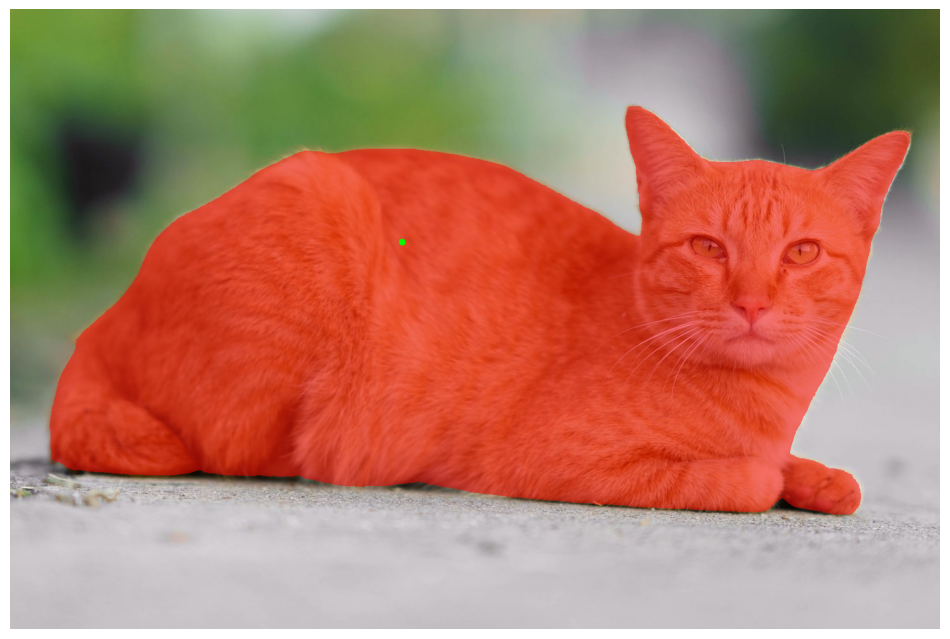

In [ ]:
if not uploaded:
    print("No file uploaded. Please upload an image to continue.")
else:
    IMAGE_PATH = list(uploaded.keys())[0]
    TEXT_PROMPT = "A CAT"

    # --- Load image using PIL ---
    image = Image.open(IMAGE_PATH).convert("RGB")
    image_bgr = cv2.imread(IMAGE_PATH) # For final visualization

    # --- 1. Get heatmap from CLIPSeg ---
    inputs = clipseg_processor(text=[TEXT_PROMPT], images=[image], padding="max_length", return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = clipseg_model(**inputs)

    # Resize heatmap to match original image size
    heatmap = torch.sigmoid(outputs.logits).squeeze().cpu().numpy()
    heatmap = cv2.resize(heatmap, (image.width, image.height))

    # --- 2. Convert heatmap to a point prompt for SAM 2 ---
    # Find the coordinates of the brightest point in the heatmap
    # Find the coordinates of the brightest point in the heatmap
    max_coords = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    point_prompt = np.array([[max_coords[1], max_coords[0]]]) # Shape (1, 2)
    point_label = np.array([1]) # 1 indicates a foreground point

    # Reshape point_prompt to the required (1, 1, 2) format
    # This can be done by reshaping or adding a new axis
    point_prompt_reshaped = point_prompt.reshape(1, 1, 2)


    # Create a KeyPoints object from your reshaped NumPy array
    key_points_object = sv.KeyPoints(xy=point_prompt_reshaped)

    # --- 3. Feed point to SAM 2 ---
    sam2_predictor.set_image(np.array(image))
    masks, scores, logits = sam2_predictor.predict(
        point_coords=point_prompt,
        point_labels=point_label,
        multimask_output=False,
    )

    # --- Convert masks to boolean NumPy array for supervision ---
    # Assuming masks are probability or logit outputs, threshold them
    binary_masks = (masks > 0.5).astype(bool)



    # --- 4. Visualize the result ---
    mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
    point_annotator = sv.VertexAnnotator(color=sv.Color.GREEN, radius=5)

    # Create a Detections object for annotation
    final_detections = sv.Detections(
        xyxy=m2xyxy(masks=binary_masks),
        mask=binary_masks
    )

    annotated_image = mask_annotator.annotate(
        scene=image_bgr.copy(),
        detections=final_detections
    )
    # key_points_object = sv.KeyPoints(xy=point_prompt)
    # Also draw the point we used as a prompt
    # Pass the KeyPoints object to the annotator
    annotated_image = point_annotator.annotate(
        scene=annotated_image,
        key_points=key_points_object
    )

    # Display the result
    print(f"Displaying mask for: '{TEXT_PROMPT}'")
    sv.plot_image(annotated_image)